# 7. Convolutional Models

## 7.1 Import Libraries

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

2024-02-11 13:28:24.920491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 13:28:25.461433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 Physical GPUs, 1 Logical GPUs


2024-02-11 13:28:26.344551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 13:28:26.357827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 13:28:26.357877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 13:28:26.359794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 13:28:26.359836: I tensorflow/compile

In [2]:
import sys, random, gc, json, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import StringIO
      
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, ZeroPadding2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.backend import clear_session
from tensorflow.errors import ResourceExhaustedError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## 7.2 Load Sorted Data

In [4]:
def get_image_paths(data_dir):
    image_paths = []
    for root, dirs, files in os.walk(data_dir):
        if set('junk' in root.split(os.sep):
            # Skip 'junk' folder
            continue
        # Iterate 'non-junk' files in folder
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_image_paths("../02. Datasets/Images")
df = pd.DataFrame(image_paths, columns=['image_path'])
df['class'] = df['image_path'].apply(lambda x: x.split('/')[-2])

print(len(image_paths))
image_paths[0:2]

17939


['../02. Datasets/Images/Erythrasma/link.springer.com_en_18.jpg',
 '../02. Datasets/Images/Erythrasma/facebook.com_en_6.jpg']

## 7.3 Pre-processing

### 7.3.1 Class Balancing

In [5]:
# Filter out classes with too little samples (min. 2 samples per class is needed for stratify split)
class_counts = df['class'].value_counts()
retain_classes = class_counts[class_counts > 10].index
df = df[df['class'].isin(retain_classes)]
label_encoder = LabelEncoder()
label_encoder.fit(df['class'].unique())
print(f"Classes: {len(label_encoder.classes_)}")

Classes: 71


In [6]:
pd.set_option('display.max_rows', None)
df['class'].value_counts()

class
Dermatitis, Atopic                         997
Pityriasis Rosea                           787
Dermatitis, Seborrheic                     676
Keratosis, Seborrheic                      550
Alopecia Areata                            547
Onychomycosis                              538
Dermatitis, Photoallergic                  480
Port-Wine Stain                            430
Acne Keloid                                420
Blister                                    419
Onycholysis                                388
Dermatitis, Perioral                       385
Acne Conglobata                            383
Vitiligo                                   371
Scabies                                    368
Eczema, Dyshidrotic                        345
Molluscum Contagiosum                      338
Kaposi Varicelliform Eruption              337
Cafe-au-Lait Spots                         334
Impetigo                                   323
Dermatomyositis                            321
Sunburn

### 7.3.2 Split into Train(80)/Validation(10)/Test(10) sets

In [7]:
# Split into train & test set
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=16)

# Further split the train set into train & validation set
train_df, val_df = train_test_split(train_df, test_size=0.1111111111111111, stratify=train_df['class'], random_state=16) # 0.25 x 0.8 = 0.2

In [8]:
def generate_split_report(train_df, val_df, test_df):
    # Calculate counts for each class in each dataset
    train_counts = train_df['class'].value_counts()
    val_counts = val_df['class'].value_counts()
    test_counts = test_df['class'].value_counts()

    # Number of unique classes in each set
    unique_classes_train = len(train_counts)
    unique_classes_val = len(val_counts)
    unique_classes_test = len(test_counts)

    # Print unique classes to confirm if class sizes across sets are equal
    print(f"Classes in Train set: {unique_classes_train}")
    print(f"Classes in Validation set: {unique_classes_val}")
    print(f"Classes in Test set: {unique_classes_test}")
    
    # Create a DataFrame from the counts
    distribution_df = pd.DataFrame({
        'Class': train_counts.index,
        'Train': train_counts.values,
        'Validation': val_counts[train_counts.index].values,
        'Test': test_counts[train_counts.index].values
    })

    return distribution_df

split_report_df = generate_split_report(train_df, val_df, test_df)
split_report_df

Classes in Train set: 71
Classes in Validation set: 71
Classes in Test set: 71


,Class,Train,Validation,Test
0,"Dermatitis, Atopic",797,100,100
1,Pityriasis Rosea,629,79,79
2,"Dermatitis, Seborrheic",540,68,68
3,"Keratosis, Seborrheic",440,55,55
4,Alopecia Areata,437,55,55
5,Onychomycosis,430,54,54
6,"Dermatitis, Photoallergic",384,48,48
7,Port-Wine Stain,344,43,43
8,Acne Keloid,336,42,42
9,Blister,335,42,42


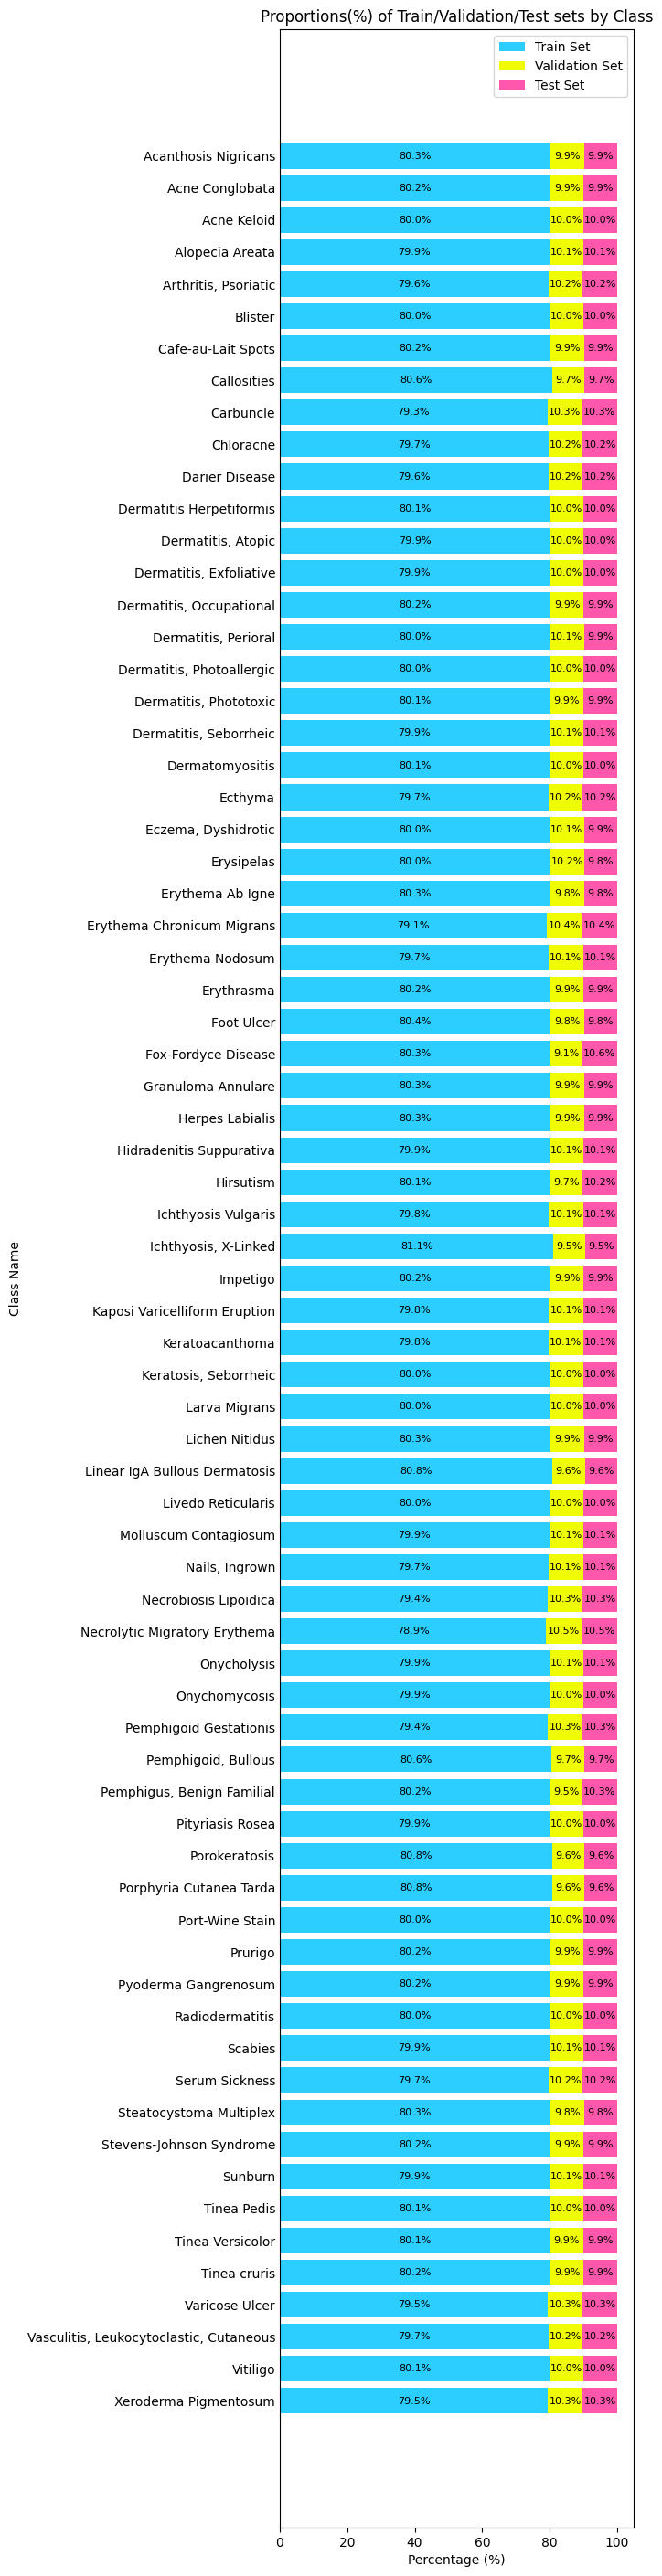

In [9]:
def plot_stacked_bar_chart(df):
    df = df.copy()
    df = df.sort_values('Class', ascending=False)
    df['totalCount'] = df['Train'] + df['Validation'] + df['Test']
    df['trainPercent'] = df['Train'] / df['totalCount'] * 100
    df['validationPercent'] = df['Validation'] / df['totalCount'] * 100
    df['testPercent'] = df['Test'] / df['totalCount'] * 100
    height_per_class = 0.5
    total_classes = len(df['Class'])
    fig_height = height_per_class * total_classes
    fig, ax = plt.subplots(figsize=(5, fig_height))

    # Add labels & title
    ax.set_title('Proportions(%) of Train/Validation/Test sets by Class')
    ax.set_xlabel('Percentage (%)')
    ax.set_ylabel('Class Name')
    ax.tick_params(axis='y', length=0)
    bars_train = ax.barh(df['Class'], df['trainPercent'], color='#2bceff', label='Train Set')
    bars_validation = ax.barh(df['Class'], df['validationPercent'], color='#f0fc03', left=df['trainPercent'], label='Validation Set')
    bars_test = ax.barh(df['Class'], df['testPercent'], color='#ff57ab', left=df['trainPercent'] + df['validationPercent'], label='Test Set')

    # Annotate bars with (%) values
    for bars in [bars_train, bars_validation, bars_test]:
        for bar in bars:
            if bar.get_width() > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                        f"{bar.get_width():.1f}%", va='center', ha='center', color='black', fontsize=8)
    ax.legend()
    plt.show()

plot_stacked_bar_chart(split_report_df)

### 7.3.3 Data Generators for Augmentation & Preprocessing 

In [10]:
# Create an ImageDataGenerator for raw data Pre-processing
imageDataGenerator = ImageDataGenerator(
    # --- Pre-processing ---
    rescale=1./255,        # normalize (re-scale) pixel values to [0,1] range, by dividing by 255
    fill_mode='constant',  # deal with resizing issues(aspect ratio don't match target size) by filling areas outside the image boundaries with a constant pixel color
    cval=0,                # constant fill color to use if fill_mode is 'constant'. 0 to fill with black pixels
)

## 7.4 Deep Learning

### 7.4.1 Design Convolutional Architecture: Convolutional Neural Network(CNN)

#### 7.4.1.1 Overview

<u>Architecture Overview</u>

**Input Layer**
- add an Input layer to fetch raw image data as an input array, without modifications to its original 2D/3D formats

<hr>

**Convolutional Layer 1**
- add 1st Conv2D layer (32 filters, each having a 3x3 kernel | ReLU Activation)
- the layer applies each of the 32 filters individually on the input images, by sliding over patches of an input image to extract basic elementary features (eg. colors, borders). These features are then outputted as a feature map (matrix)

**Batch Normalization Layer 1**
- add 1st BatchNormalization layer to normalize feature map values of the convolutional layer by standardizing inputs of each mini-batch. This adjusts the mean output to be closer to 0 and scales standard deviation(s.d) to be closer to 1 for each mini-batch
- this normalization speeds up layer convergence by reducing the internal covariate shift which helps stabilize & speed up the entire training process
- it introduce minor noise for subtle regularization to reduce overfitting
  
**Pooling Layer 1**
- add 1st MaxPooling2D layer (2x2 pool size) to select the largest value found within each patch of the 2x2 pooling sliding window of the feature map
- the layer reduces the spatial size(dimension) of the feature map extracted by the convolutional layer to reduce complexity & overfitting

<hr>

**Convolutional Layer 2**
- add 2nd Conv2D layer (64 filters, each having a 3x3 kernel | ReLU Activation)
- the layer builds upon the 1st convolutional layer to expand extraction of basic elementary features(eg. textures, shapes) from input images

**Batch Normalization Layer 2**
- add 2nd BatchNormalization layer to normalize feature map values of the convolutional layer

**Pooling Layer 2**
- add 2nd MaxPooling2D layer (2x2 pool size) to down-sample feature map

<hr>

**Flatten Layer 1**
- add 1st Flatten layer to convert the output of the previous pooling layer into a 1D array, so that it can be processed by dense layers

**Dense Layer 1**
- add 1st Dense layer (128 Neurons, ReLU Activation) to learn patterns from the flattened data

**Dropout Layer 1**
- add 1st Regularization layer (50% Dropout Rate) to randomly select a subset of neurons to ignore during training

<hr>

**Output Layer**
- add Final Dense layer (Neurons = Number of Classes, Softmax Activation)
- the layer outputs a probability distribution over the classes for multi-class classification to determine the classification likelihood per class, for a given input

#### 7.4.1.2 Design Multiple Architectures & Neural Network Configurations

In [11]:
# --- Classes --- 
NUM_CLASSES = len(label_encoder.classes_)  # total number of unique classes to predict
# set class weights for unabalanced classes
# CLASS_WEIGHTS = compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
# CLASS_WEIGHTS = dict(enumerate(CLASS_WEIGHTS))
CLASS_WEIGHTS = None

# --- Pre-processing Parameters-Images --- 
TARGET_IMG_WIDTH = 256          # image width
TARGET_IMG_HEIGHT = 256         # image height
TARGET_IMG_COLOR_CHANNELS = 3   # number of color channels (3 for RGB channels)
TARGET_BATCH_SIZE = 32          # number of images to process in a single batch, during training
INPUT_SHAPE = (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_COLOR_CHANNELS)

# --- CNN Architectures ---  index represents the corresponding model number
CNN_ARCHITECTURES = {
    0: {  # Architecture 1
        'DESCRIPTION': '6 layers',
        'CONV_BLOCKS': [
            {   # BLOCK_1
                'FILTERS': [32],
                'FILTERS_SIZE': [(4, 4)] * 1,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (1, 1),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_2
                'FILTERS': [64],
                'FILTERS_SIZE': [(3, 3)] * 1,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_3
                'FILTERS': [128],
                'FILTERS_SIZE': [(3, 3)] * 1,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_4
                'FILTERS': [256],
                'FILTERS_SIZE': [(3, 3)] * 1,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_5
                'FILTERS': [512],
                'FILTERS_SIZE': [(3, 3)] * 1,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_LAST
                'DENSE_NEURONS': [1024],
                'DENSE_ACTIVATION': ['relu'],
                'DROPOUT_RATE': [0.1],
                'LAST_LAYER_ACTIVATION': 'softmax'
            }
        ]
    },
    1: {  # Architecture 2
        'DESCRIPTION': '12 layers',
        'CONV_BLOCKS': [
            {   # BLOCK_1
                'FILTERS': [32, 32, 32],
                'FILTERS_SIZE': [(4, 4)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (1, 1),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_2
                'FILTERS': [64, 64, 64],
                'FILTERS_SIZE': [(3, 3)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_3
                'FILTERS': [128, 128, 128],
                'FILTERS_SIZE': [(3, 3)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_4
                'FILTERS': [256, 256],
                'FILTERS_SIZE': [(3, 3)] * 2,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_LAST
                'DENSE_NEURONS': [1024],
                'DENSE_ACTIVATION': ['relu'],
                'DROPOUT_RATE': [0.1],
                'LAST_LAYER_ACTIVATION': 'softmax'
            }
        ]
    },
    2: {  # Architecture 3
        'DESCRIPTION': '19 layers',
        'CONV_BLOCKS': [
            {   # BLOCK_1
                'FILTERS': [32, 32, 32],
                'FILTERS_SIZE': [(4, 4)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (1, 1),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_2
                'FILTERS': [64, 64, 64],
                'FILTERS_SIZE': [(3, 3)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_3
                'FILTERS': [128, 128, 128],
                'FILTERS_SIZE': [(3, 3)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_4
                'FILTERS': [256, 256, 256],
                'FILTERS_SIZE': [(3, 3)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_5
                'FILTERS': [512, 512, 512],
                'FILTERS_SIZE': [(3, 3)] * 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_6
                'FILTERS': [1024, 1024, 1024],
                'FILTERS_SIZE': [(3, 3)]* 3,
                'MAXPOOL_SIZE': (2, 2),
                'MAXPOOL_STRIDE': (2, 2),
                'BATCH_NORMALIZATION': 1
            },
            {   # BLOCK_LAST
                'DENSE_NEURONS': [1024],
                'DENSE_ACTIVATION': ['relu'],
                'DROPOUT_RATE': [0.1],
                'LAST_LAYER_ACTIVATION': 'softmax'
            }
        ]
    }
}

# --- Training Configurations ---
EPOCHS = 50                                 # number of complete passes to run
LOSS_FUNCTION = 'categorical_crossentropy'  # for multi-class single-label problems
LEARNING_RATE = 0.001
OPTIMIZER = 'adam'

# --- Callbacks ---
class CallbacksManager:
    def get_callbacks(self):
        # Schedule learning rate - to dynamically adjust learning rate based on rate of change in validation loss during training
        LR_SCHEDULER = ReduceLROnPlateau(
            monitor='val_loss',   # reduce learning rate when validation loss metric stopped improving
            factor=0.1, 
            patience=5,
            min_lr=0.00001, 
            verbose=1
        )
        
        # Stop training early, to reduce over-fitting
        EARLY_STOP = EarlyStopping(
            monitor='val_loss',
            patience=10
        )
        
        return [LR_SCHEDULER, EARLY_STOP]
CALLBACKSmanager = CallbacksManager()

# --- Optimizer ---  to optimize adaptive learning rate
class OptimizerManager:
    def get_optimizer(self, optimizer_name, learning_rate):
        if optimizer_name == 'adam':
            return Adam(learning_rate=learning_rate)    # general choice - suit most cases
        elif optimizer_name == 'sgd':
            return SGD(learning_rate=learning_rate)     # classic choice - suit simple models with small datasets
        elif optimizer_name == 'rmsprop':
            return RMSprop(learning_rate=learning_rate) # adaptive choice - suit problems with noisy or non-stationary data
        else:
            raise ValueError("No such optimizer")
            
OPTIMIZERMANAGER = OptimizerManager()

# --- Performance Evaluation Metrics ---
EVALUATION_METRICS = ['accuracy', Precision(name='precision'), Recall(name='recall')]

### 7.4.2 Data Generators for Training/Validation/Testing

In [12]:
# Create generator for training data
TRAIN_DAT_GENERATOR = imageDataGenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',                                 # df column of 'image paths'
    y_col='class',                                      # df column of 'class labels'
    target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),  # re-size image to specific size
    batch_size=TARGET_BATCH_SIZE,                       # total images to yield from the generator, per batch
    class_mode='categorical',                           # one-hot encode all class labels
    drop_remainder=True                                 # ensure all batches have same size by dropping last batch in each epoch if test_set_size is not divisible by TARGET_BATCH_SIZE
)

# Create generator for validation data
VAL_DAT_GENERATOR = imageDataGenerator.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='class',
    target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
    batch_size=TARGET_BATCH_SIZE,
    class_mode='categorical',
    drop_remainder=True
)

# Create generator for test data
TEST_DAT_GENERATOR = imageDataGenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='class',
    target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
    batch_size=TARGET_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    drop_remainder=True
)

Found 14351 validated image filenames belonging to 71 classes.
Found 1794 validated image filenames belonging to 71 classes.
Found 1794 validated image filenames belonging to 71 classes.


### 7.4.3 Iterative Model Development

In [13]:
global_CNN_histories = {}
global_CNN_stack_summaries = []
global_CNN_test_predictions = {}

#### 7.4.3.1 Model Compilation- Conv Blocks Implementation Method

In [14]:
class ConvolutionalNeuralNetwork:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.num_classes = num_classes

    def add_convolutional_blocks(self, model_idx):
        self.model.add(InputLayer(input_shape=INPUT_SHAPE))
        for block in CNN_ARCHITECTURES[model_idx]['CONV_BLOCKS'][:-1]:
            for i in range(len(block['FILTERS'])):
                self.model.add(Conv2D(block['FILTERS'][i], block['FILTERS_SIZE'][i], activation='relu'))
            if block.get('BATCH_NORMALIZATION'):
                self.model.add(BatchNormalization())
            if block.get('MAXPOOL_SIZE') is not None:
                self.model.add(MaxPooling2D(pool_size=block['MAXPOOL_SIZE'], strides=block.get('MAXPOOL_STRIDE')))

    def add_final_block(self, model_idx):
        self.model.add(Flatten())
        last_block = CNN_ARCHITECTURES[model_idx]['CONV_BLOCKS'][-1]
        dense_neurons = last_block.get('DENSE_NEURONS', [])
        dense_activation = last_block.get('DENSE_ACTIVATION', [])
        dropout_rate = last_block.get('DROPOUT_RATE', [])
        for i in range(len(dense_neurons)):
            self.model.add(Dense(dense_neurons[i], activation=dense_activation[i]))
            self.model.add(Dropout(dropout_rate[i]))
        last_layer_activation = last_block.get('LAST_LAYER_ACTIVATION', 'softmax')
        self.model.add(Dense(self.num_classes, activation=last_layer_activation))
        
    def compile_model(self, optimizer, loss_function, metrics):
        self.model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    def train(self, train_data, val_data, epochs, callbacks):
        return self.model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks, verbose=1)

    def evaluate(self, test_data):
        test_results = self.model.evaluate(test_data)
        if len(test_results) >= 4:
            precision = test_results[2]
            recall = test_results[3]
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
            test_results.append(f1_score)
        return test_results

    def predict(self, test_data, steps):
        return self.model.predict(test_data, steps=steps)
        
    def save(self, modelNo, DESCRIPTION):
        self.model.save(f"../04. Trained_Models/custom_CNN_{modelNo}_{DESCRIPTION}.tf")
        
# Function to train & evaluate the model
def train_and_evaluate_model(model_idx, model):
    model.add_convolutional_blocks(model_idx)
    model.add_final_block(model_idx)
    model.compile_model(
        optimizer=OPTIMIZERMANAGER.get_optimizer(OPTIMIZER, LEARNING_RATE),
        loss_function=LOSS_FUNCTION,
        metrics=EVALUATION_METRICS
    )
    train_val_history = model.train(TRAIN_DAT_GENERATOR, VAL_DAT_GENERATOR, epochs=EPOCHS, callbacks=CALLBACKSmanager.get_callbacks())
    TEST_DAT_GENERATOR.reset()
    steps = len(TEST_DAT_GENERATOR)
    preds = model.predict(TEST_DAT_GENERATOR, steps=steps)
    test_predictions = np.argmax(preds, axis=1)
    test_true_labels = TEST_DAT_GENERATOR.classes
    TEST_DAT_GENERATOR.reset()
    test_history = model.evaluate(TEST_DAT_GENERATOR)
    return train_val_history.history, test_history, (test_predictions, test_true_labels)

# Function to record summary of model stack
def record_modelStack_summary(model):
    old_stdout = sys.stdout
    sys.stdout = buffer = StringIO()
    model.summary()
    sys.stdout = old_stdout
    global_CNN_stack_summaries.append(buffer.getvalue())

#### 7.4.3.2 Train/Validate/Test Multiple Models at the same time, in sequence

In [15]:
# Iteratively train & evaluate models
for i in range(len(CNN_ARCHITECTURES.keys())):
    print(f"Running: Model {i}, {CNN_ARCHITECTURES[i]['DESCRIPTION']}")
    CNN_model = ConvolutionalNeuralNetwork(NUM_CLASSES)
    train_val_history, test_history, (test_predictions, test_true_labels)  = train_and_evaluate_model(i, CNN_model)
    record_modelStack_summary(CNN_model.model)
    global_CNN_histories[i] = {
        "train_val_history": train_val_history,
        "test_history": test_history,
        "description": CNN_ARCHITECTURES[i]['DESCRIPTION']
    }
    global_CNN_test_predictions[i] = {
        "predictions": test_predictions,
        "true_labels": test_true_labels,
        "description": CNN_ARCHITECTURES[i]['DESCRIPTION']
    }
    # Export trained model
    CNN_model.save(i, CNN_ARCHITECTURES[i]['DESCRIPTION'])
    time.sleep(30)
    
    # Clear model from memory to free up resources
    del CNN_model
    gc.collect()
    time.sleep(10)

Running: Model 0, 6 layers
Epoch 1/50


2024-02-11 13:29:05.046917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-02-11 13:29:06.292586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-11 13:29:06.317562: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f08c4055cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-11 13:29:06.317596: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-11 13:29:06.321030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-11 13:29:06.415407: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

449/449 [==============================] - 96s 196ms/step - loss: 8.6434 - accuracy: 0.0462 - precision: 0.0391 - recall: 0.0052 - val_loss: 4.2076 - val_accuracy: 0.0530 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 85s 190ms/step - loss: 4.2148 - accuracy: 0.0549 - precision: 0.1429 - recall: 2.7873e-04 - val_loss: 4.1819 - val_accuracy: 0.0574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 85s 190ms/step - loss: 4.1333 - accuracy: 0.0568 - precision: 0.4000 - recall: 4.1809e-04 - val_loss: 4.1716 - val_accuracy: 0.0535 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 85s 189ms/step - loss: 4.0894 - accuracy: 0.0558 - precision: 0.3333 - recall: 2.0904e-04 - val_loss: 4.1094 - val_accuracy: 0.0530 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 5

INFO:tensorflow:Assets written to: ../04. Trained_Models/custom_CNN_0_6 layers.tf/assets


Running: Model 1, 12 layers
Epoch 1/50
449/449 [==============================] - 223s 450ms/step - loss: 9.4274 - accuracy: 0.0429 - precision: 0.0220 - recall: 0.0025 - val_loss: 4.3341 - val_accuracy: 0.0412 - val_precision: 0.2286 - val_recall: 0.0089 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 193s 430ms/step - loss: 4.0901 - accuracy: 0.0621 - precision: 0.1842 - recall: 4.8777e-04 - val_loss: 4.1953 - val_accuracy: 0.0535 - val_precision: 0.0625 - val_recall: 5.5741e-04 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 193s 430ms/step - loss: 4.0006 - accuracy: 0.0739 - precision: 0.4490 - recall: 0.0015 - val_loss: 4.0206 - val_accuracy: 0.0702 - val_precision: 0.5000 - val_recall: 5.5741e-04 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 193s 430ms/step - loss: 3.9120 - accuracy: 0.0826 - precision: 0.6211 - recall: 0.0041 - val_loss: 3.9663 - val_accuracy: 0.0769 - val_precision: 0.6154 - val_recall: 0.0045 - lr: 0.0

INFO:tensorflow:Assets written to: ../04. Trained_Models/custom_CNN_1_12 layers.tf/assets


Running: Model 2, 19 layers
Epoch 1/50
449/449 [==============================] - 229s 491ms/step - loss: 4.3311 - accuracy: 0.0461 - precision: 0.3838 - recall: 0.0141 - val_loss: 4.1674 - val_accuracy: 0.0351 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 218s 486ms/step - loss: 4.0661 - accuracy: 0.0544 - precision: 0.1250 - recall: 6.9682e-05 - val_loss: 4.2148 - val_accuracy: 0.0485 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 218s 486ms/step - loss: 4.0516 - accuracy: 0.0525 - precision: 0.1250 - recall: 6.9682e-05 - val_loss: 4.0502 - val_accuracy: 0.0552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 219s 487ms/step - loss: 4.0251 - accuracy: 0.0611 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 5.0446 - val_accuracy: 0.0513 - val_precision: 0.0345 - 

INFO:tensorflow:Assets written to: ../04. Trained_Models/custom_CNN_2_19 layers.tf/assets


## Export global_CNN_histories to a static .JSON file

In [20]:
global_CNN_histories

def convert(o):
    if isinstance(o, np.float32):
        return float(o)
    raise TypeError

try:
    with open('../03. Outputs/custom_CNN_histories.json', 'w') as file:
        json.dump(global_CNN_histories, file, default=convert)
        print("Export is successful. File saved as 'custom_CNN_histories.json'")
except Exception as e:
    print("An error occurred:", e)

Export is successful. File saved as 'custom_CNN_histories.json'


#### 7.4.3.3 View Model Architecture Stack

In [21]:
for i in range(len(CNN_ARCHITECTURES.keys())):
    print("-"*40)
    print(f"'Model {i + 1}: {CNN_ARCHITECTURES[i]['DESCRIPTION']}'")
    print("-"*40)
    print(global_CNN_stack_summaries[i])
    print("="*95)

----------------------------------------
'Model 1: 6 layers'
----------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 batch_normalization (Batch  (None, 253, 253, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 252, 252, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 250, 250, 64)      256       
 chNormalization)   

#### 7.4.3.4 Overview of Validation Strategy

The project uses `Holdout Validation` & `Early Stopping` approach to validate model performance

**`K-Fold Cross-Validation`**

Although K-fold cross-validation is very thorough in evaluating models, it will not be used in this project due to resource limitations. It is impractical/infeasible to train the model multiple times(once per fold) on the dataset acquired in this project due to it's large size(estimated at 1~2GB). There is insufficient funds for cloud computing resources(google colab subscription) and insufficient project time(need to meet project deadline) to perform k-fold evaluation on each iterated model architecture. Also, k-fold is not compulsory for getting a reasonable evaluation on the dataset

**`Holdout Validation`**

To address limitations in computational resources & project time, holdout validation will be used to assess model performance. A portion of the training data will be set aside for both validation(validation set) & testing(test set) during dataset splitting. This approach avoids the need to conduct repetitive training cycles and can be used to evaluate model performance in a straightforward efficient manner using separate non-overlapping sets for training/validation/testing. Standard classification evaluation metrics can be used to determine how well the model make predictions on new data and gauge it's ability to generalize to unseen data using this approach

**`Early Stopping`**

To prevent over-training, early stopping will be used as a safeguard to to speed up training times by terminating the training process when there is no signs of further improvements in model performance on the validation set over a specified number of epochs. Early stopping ensures the model does not learn patterns that don't generalize well to unseen data, which helps prevent over-fitting as well. By continuously monitoring the model's performance on the validation set(specifically looking at validation loss metrics), it will allow training to be stopped earlier at the right time without compromising model performance 

#### 7.4.3.5 Training vs. Validation Loss

In [22]:
def plot_train_val_losses(model_index):
    training_loss = global_CNN_histories[model_index]['train_val_history']['loss']
    validation_loss = global_CNN_histories[model_index]['train_val_history']['val_loss']
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(10, 3))
    plt.plot(epochs, training_loss, 'b-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

----------------------------------------
'Model 1: 6 layers'
----------------------------------------


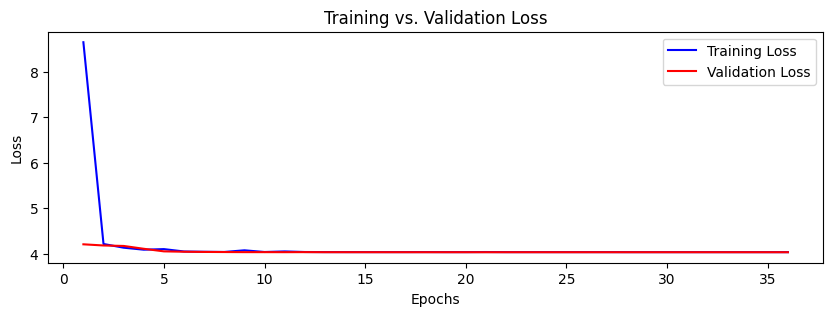

----------------------------------------
'Model 2: 12 layers'
----------------------------------------


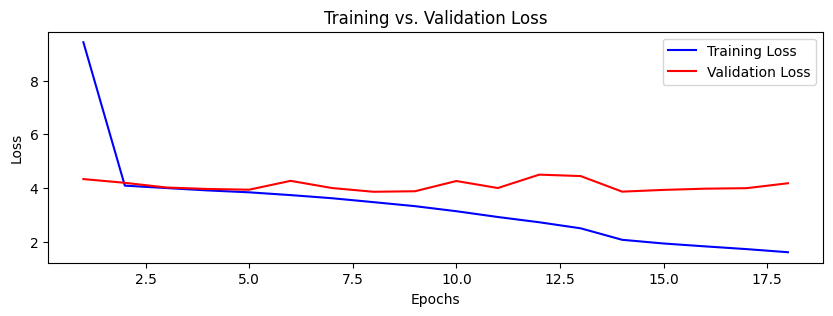

----------------------------------------
'Model 3: 19 layers'
----------------------------------------


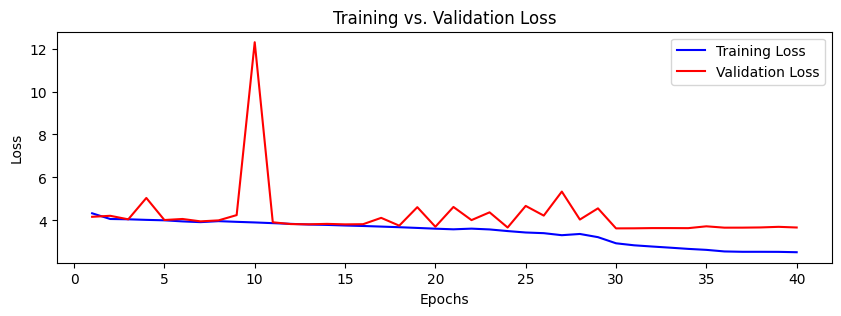

In [23]:
for i in range(len(CNN_ARCHITECTURES.keys())):
    print("-"*40)
    print(f"'Model {i + 1}: {CNN_ARCHITECTURES[i]['DESCRIPTION']}'")
    print("-"*40)
    plot_train_val_losses(i)
    print("="*95)

#### 7.4.3.6 Analyse Overall Performance Metrics

- Create a plot to analyse metrics side-by-side to see how well the model is minimizing error(loss), alongside it's classification performance. This gives insights into the model’s balance between it's learning efficiency(loss minimization) <-> decision-making accuracy(precision/recall) and help identify if improvements in loss yields better corresponding precision/recall, indicating if the model is well-balanced or not

- This will also reveal issues with code implementation that require manual correction(eg. abnormal trends in the metrics)

In [24]:
def plot_overall_performance_metrics(model_index):
    training_precision = global_CNN_histories[model_index]['train_val_history']['precision']
    training_recall = global_CNN_histories[model_index]['train_val_history']['recall']
    validation_precision = global_CNN_histories[model_index]['train_val_history']['val_precision']
    validation_recall = global_CNN_histories[model_index]['train_val_history']['val_recall']
    training_loss = global_CNN_histories[model_index]['train_val_history']['loss']
    validation_loss = global_CNN_histories[model_index]['train_val_history']['val_loss']
    epochs = range(1, len(training_loss) + 1)
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training / Validation Loss', color='tab:blue')
    ln1 = ax1.plot(epochs, training_loss, 'b-', label='Training Loss')
    ln2 = ax1.plot(epochs, validation_loss, 'b--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Precision / Recall', color='tab:red')
    ln3 = ax2.plot(epochs, training_precision, 'r-', label='Training Precision')
    ln4 = ax2.plot(epochs, training_recall, 'r--', label='Training Recall')
    ln5 = ax2.plot(epochs, validation_precision, 'g-', label='Validation Precision')
    ln6 = ax2.plot(epochs, validation_recall, 'g--', label='Validation Recall')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    lns = ln1 + ln2 + ln3 + ln4 + ln5 + ln6
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left')
    plt.title(f"Model {model_index}: Overall Performance Metrics Over Epochs")
    fig.tight_layout()
    plt.show()

----------------------------------------
'Model 1: 6 layers'
----------------------------------------


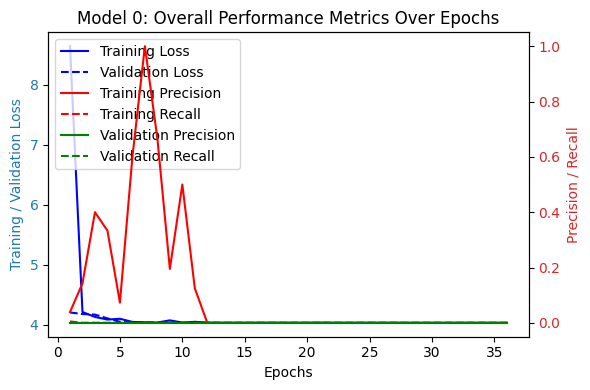

----------------------------------------
'Model 2: 12 layers'
----------------------------------------


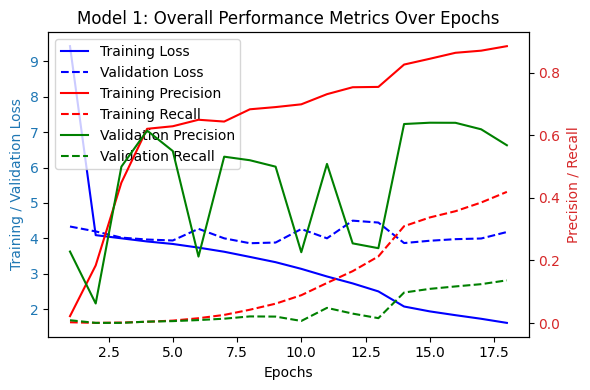

----------------------------------------
'Model 3: 19 layers'
----------------------------------------


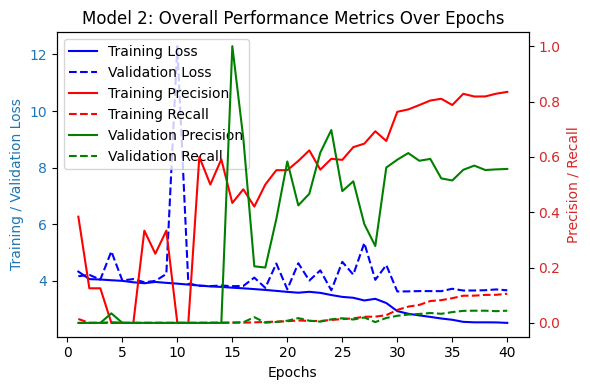

In [25]:
for i in range(len(CNN_ARCHITECTURES.keys())):
    print("-"*40)
    print(f"'Model {i + 1}: {CNN_ARCHITECTURES[i]['DESCRIPTION']}'")
    print("-"*40)
    plot_overall_performance_metrics(i)
    print("="*95)

#### 7.4.3.7 Final Evaluation on Test Set

Understand how well the model is performing for each individual class

In [26]:
def generate_classification_report(model_index):
    predictions = global_CNN_test_predictions[model_index]["predictions"]
    true_labels = global_CNN_test_predictions[model_index]["true_labels"]
    report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
    print(f"Classification Report:\n{report}")
    test_accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {test_accuracy:.4f}")

In [27]:
for i in range(len(CNN_ARCHITECTURES.keys())):
    print("-"*40)
    print(f"'Model {i + 1}: {CNN_ARCHITECTURES[i]['DESCRIPTION']}'")
    print("-"*40)
    generate_classification_report(i)
    print("="*95)

----------------------------------------
'Model 1: 6 layers'
----------------------------------------
Classification Report:
                                         precision    recall  f1-score   support

                   Acanthosis Nigricans       0.00      0.00      0.00        21
                        Acne Conglobata       0.00      0.00      0.00        38
                            Acne Keloid       0.00      0.00      0.00        42
                        Alopecia Areata       0.00      0.00      0.00        55
                   Arthritis, Psoriatic       0.00      0.00      0.00        17
                                Blister       0.00      0.00      0.00        42
                     Cafe-au-Lait Spots       0.00      0.00      0.00        33
                            Callosities       0.00      0.00      0.00         6
                              Carbuncle       0.00      0.00      0.00         6
                              Chloracne       0.00      0.00    

/home/monke/FP Code/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monke/FP Code/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monke/FP Code/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monke/FP Code/lib/python3.11/si

Show distribution of predictions across different classes and highlight areas where the model confuse itself over one class for another

In [29]:
def generate_confusion_matrix(model_index):
    predictions = global_CNN_test_predictions[model_index]["predictions"]
    true_labels = global_CNN_test_predictions[model_index]["true_labels"]
    cm = confusion_matrix(true_labels, predictions, labels=np.arange(NUM_CLASSES))
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(6, 5))
    cmp.plot(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

In [ ]:
generate_confusion_matrix(0)

#### 7.4.3.8 Compare 'Test' Performance Metrics across all custom models

In [28]:
# Import baseline model histories
with open('../03. Outputs/baseline_model_histories.json', 'r') as file:
    baseline_model_histories = json.load(file)
    
baseline_train_val_history_values = baseline_model_histories['train_val_history']
baseline_test_history_values = baseline_model_histories['test_history']

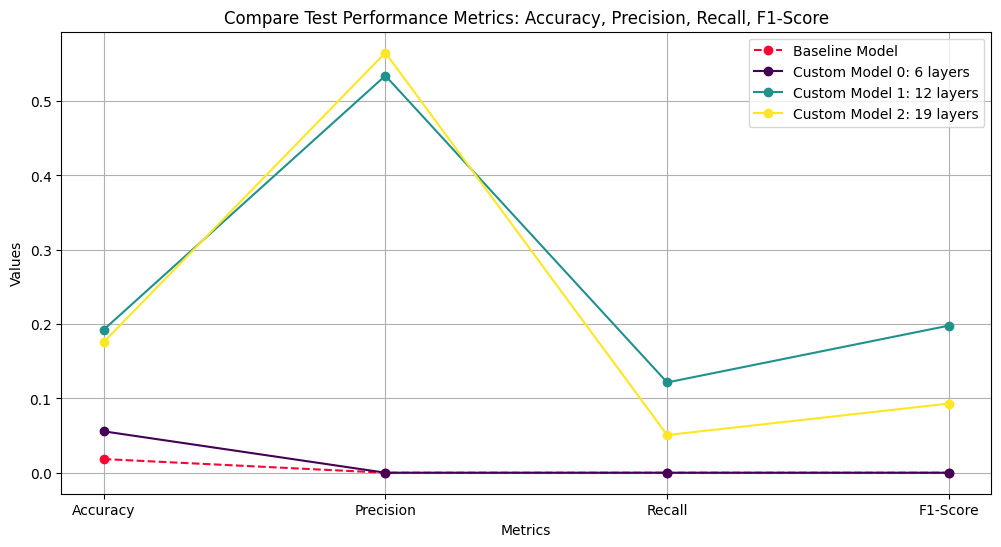

In [29]:
# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 6))
cmap = plt.colormaps['viridis']
custom_models_count = len(global_CNN_histories.keys())
values = np.linspace(0, 1, custom_models_count)
colors = cmap(values)
plt.plot(metrics, baseline_test_history_values[1:], marker='o', color='#fc0335', label='Baseline Model', linestyle='--')

# Plot test metrics for each custom model
for i, model in enumerate(enumerate(global_CNN_histories.keys())):
    descrption = global_CNN_histories[i]['description']
    plt.plot(metrics, global_CNN_histories[i]['test_history'][1:], marker='o', color=colors[i % len(colors)], label=f"Custom Model {i}: {descrption}")

plt.title('Compare Test Performance Metrics: Accuracy, Precision, Recall, F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()